# Denoising filter testing
## required libaries

In [1]:
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import median_filter
from skimage.draw import line as skidline
import functions as f

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
tiff_file  = home_dir + os.sep + '84d tiff.tif'
CT = f.CTPreprocessor(tiff_file)

Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

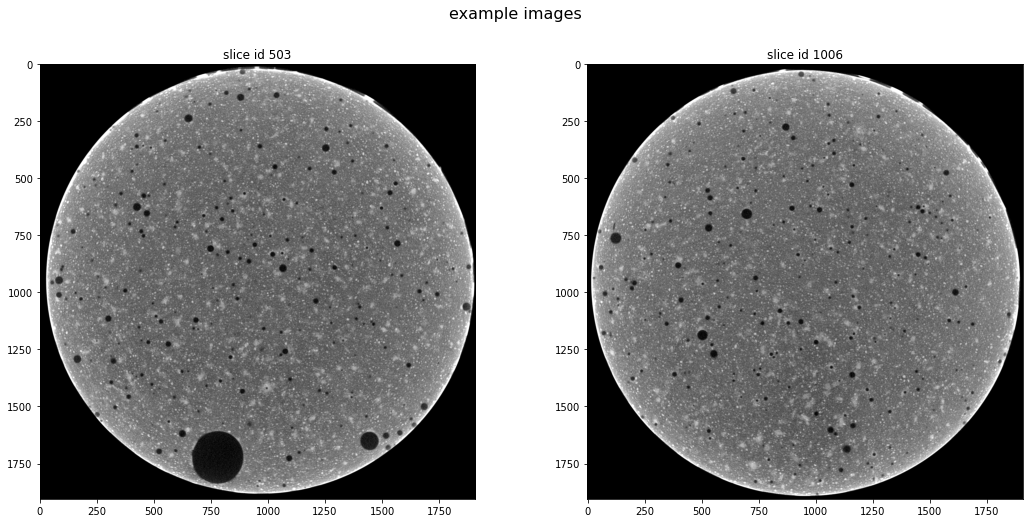

In [3]:
CT.show_example_slices()

## process the main circle, its center point and the inner pores

In [4]:
slice	= CT.select_slice(int(CT.z/3*2))

CT.identify_main_circle(threshold=20)
CT.get_main_circle()

CT.identify_pores(threshold=70)
CT.remove_pores()

found the center point at (954, 956)


## show images

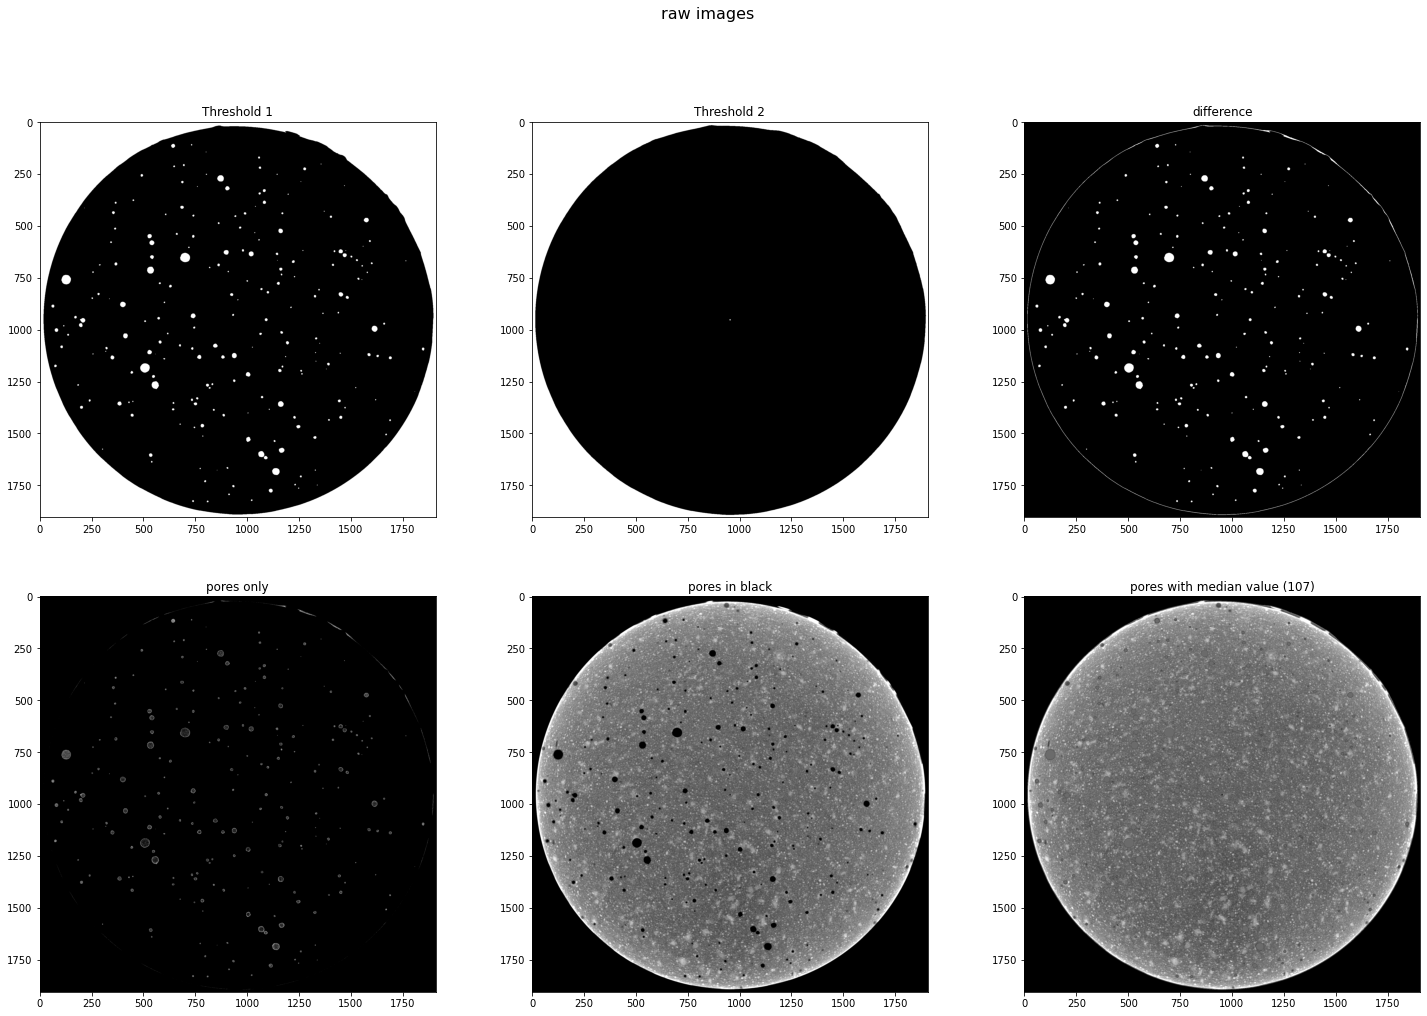

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
fig.suptitle('raw images', fontsize=16)

ax[0, 0].imshow( CT.pore_thresh, cmap='gray' )
ax[0, 0].set_title( "Threshold 1" )

ax[0, 1].imshow( CT.main_circle, cmap='gray')
ax[0, 1].set_title( "Threshold 2" )

ax[0, 2].imshow( CT.inner_pores*np.median( CT.slice ), cmap='gray' )
ax[0, 2].set_title( "difference" )

ax[1, 0].imshow( CT.slice * CT.inner_pores, cmap='gray' )
ax[1, 0].set_title( "pores only" )

ax[1, 1].imshow( CT.slice * np.logical_not(CT.inner_pores), cmap='gray' )
ax[1, 1].set_title( "pores in black" )

ax[1, 2].imshow( CT.removed_pores , cmap='gray' )
ax[1, 2].set_title( "pores replaced with median value ({:.0f})".format(np.median( CT.slice )) )

plt.show()
print()

In [6]:
angle_in_deg = 0.5
median_blur_kernel = 1
min_length = np.array( [CT.center[1], CT.h - CT.center[1], CT.center[0], CT.w - CT.center[0]] ).min()
values = np.empty( shape=(int(360/angle_in_deg), min_length), dtype=np.uint8)

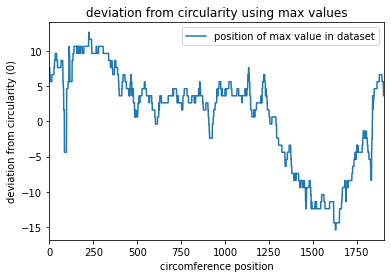

In [7]:
polar_image = cv2.linearPolar(CT.removed_pores,(CT.center[0], CT.center[1]), min_length, cv2.WARP_FILL_OUTLIERS)
mean_values = (values.sum(0)/len(polar_image)).astype(np.uint8)

median_blur_kernel = 21
max_pos = []

for i in range(len(polar_image)):
	max_pos.append(np.argmax(polar_image[i]))
	polar_image[i] = cv2.medianBlur(polar_image[i].astype(np.uint8), median_blur_kernel).flatten()

max_pos = np.array(max_pos).astype(np.uint8)
max_pos = max_pos-np.mean(max_pos)

#show uncircularity
ax = plt.axes()
#ax.set_yscale('log')
ax.plot(range(len(max_pos)), median_filter(max_pos,25 ) , label='position of max value in dataset')
ax.set_title('deviation from circularity using max values')
ax.set_ylabel('deviation from circularity (0)')
ax.set_xlim((0, len(max_pos)))
ax.set_xlabel('circomference position')
ax.legend()
plt.show()

mean_values = (polar_image.sum(0)/len(polar_image)).astype(np.uint8)

polar_background = np.empty(shape=polar_image.shape,dtype=int)
polar_background.fill(0)
for i in range(len(polar_image)):
	polar_background[i] = mean_values

max_pos = np.argmax(mean_values)+2

c + d^( d^( (x-x_0)/b ) )
x_0 = 383.23, b = 400.42, c = 102.72, d = 1.75


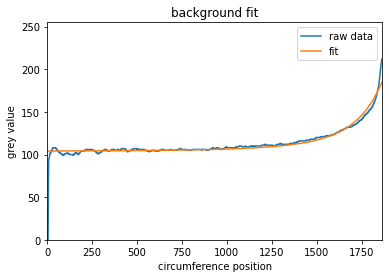

In [8]:
# find a fit function for the background
FCP = f.FitCurveProfile( mean_values )
FCP.filter_values()
FCP.fit_data()
FCP.plot_function()
fit_data = FCP.get_f_data()
FCP.plot_data()

In [9]:
# first remove the y-offset to only get the background deviation
fit_data = fit_data-fit_data.min()

# process the background
polar_background_fit = np.empty(shape=polar_image.shape,dtype=int)
polar_background_fit.fill(0)
for i in range(len(polar_image)):
	for j,v in enumerate(fit_data.astype(np.uint8)):
		polar_background_fit[i][j] = v

(1905, 1908)
(1905, 1865)


Text(0.5, 1.0, 'removed background')

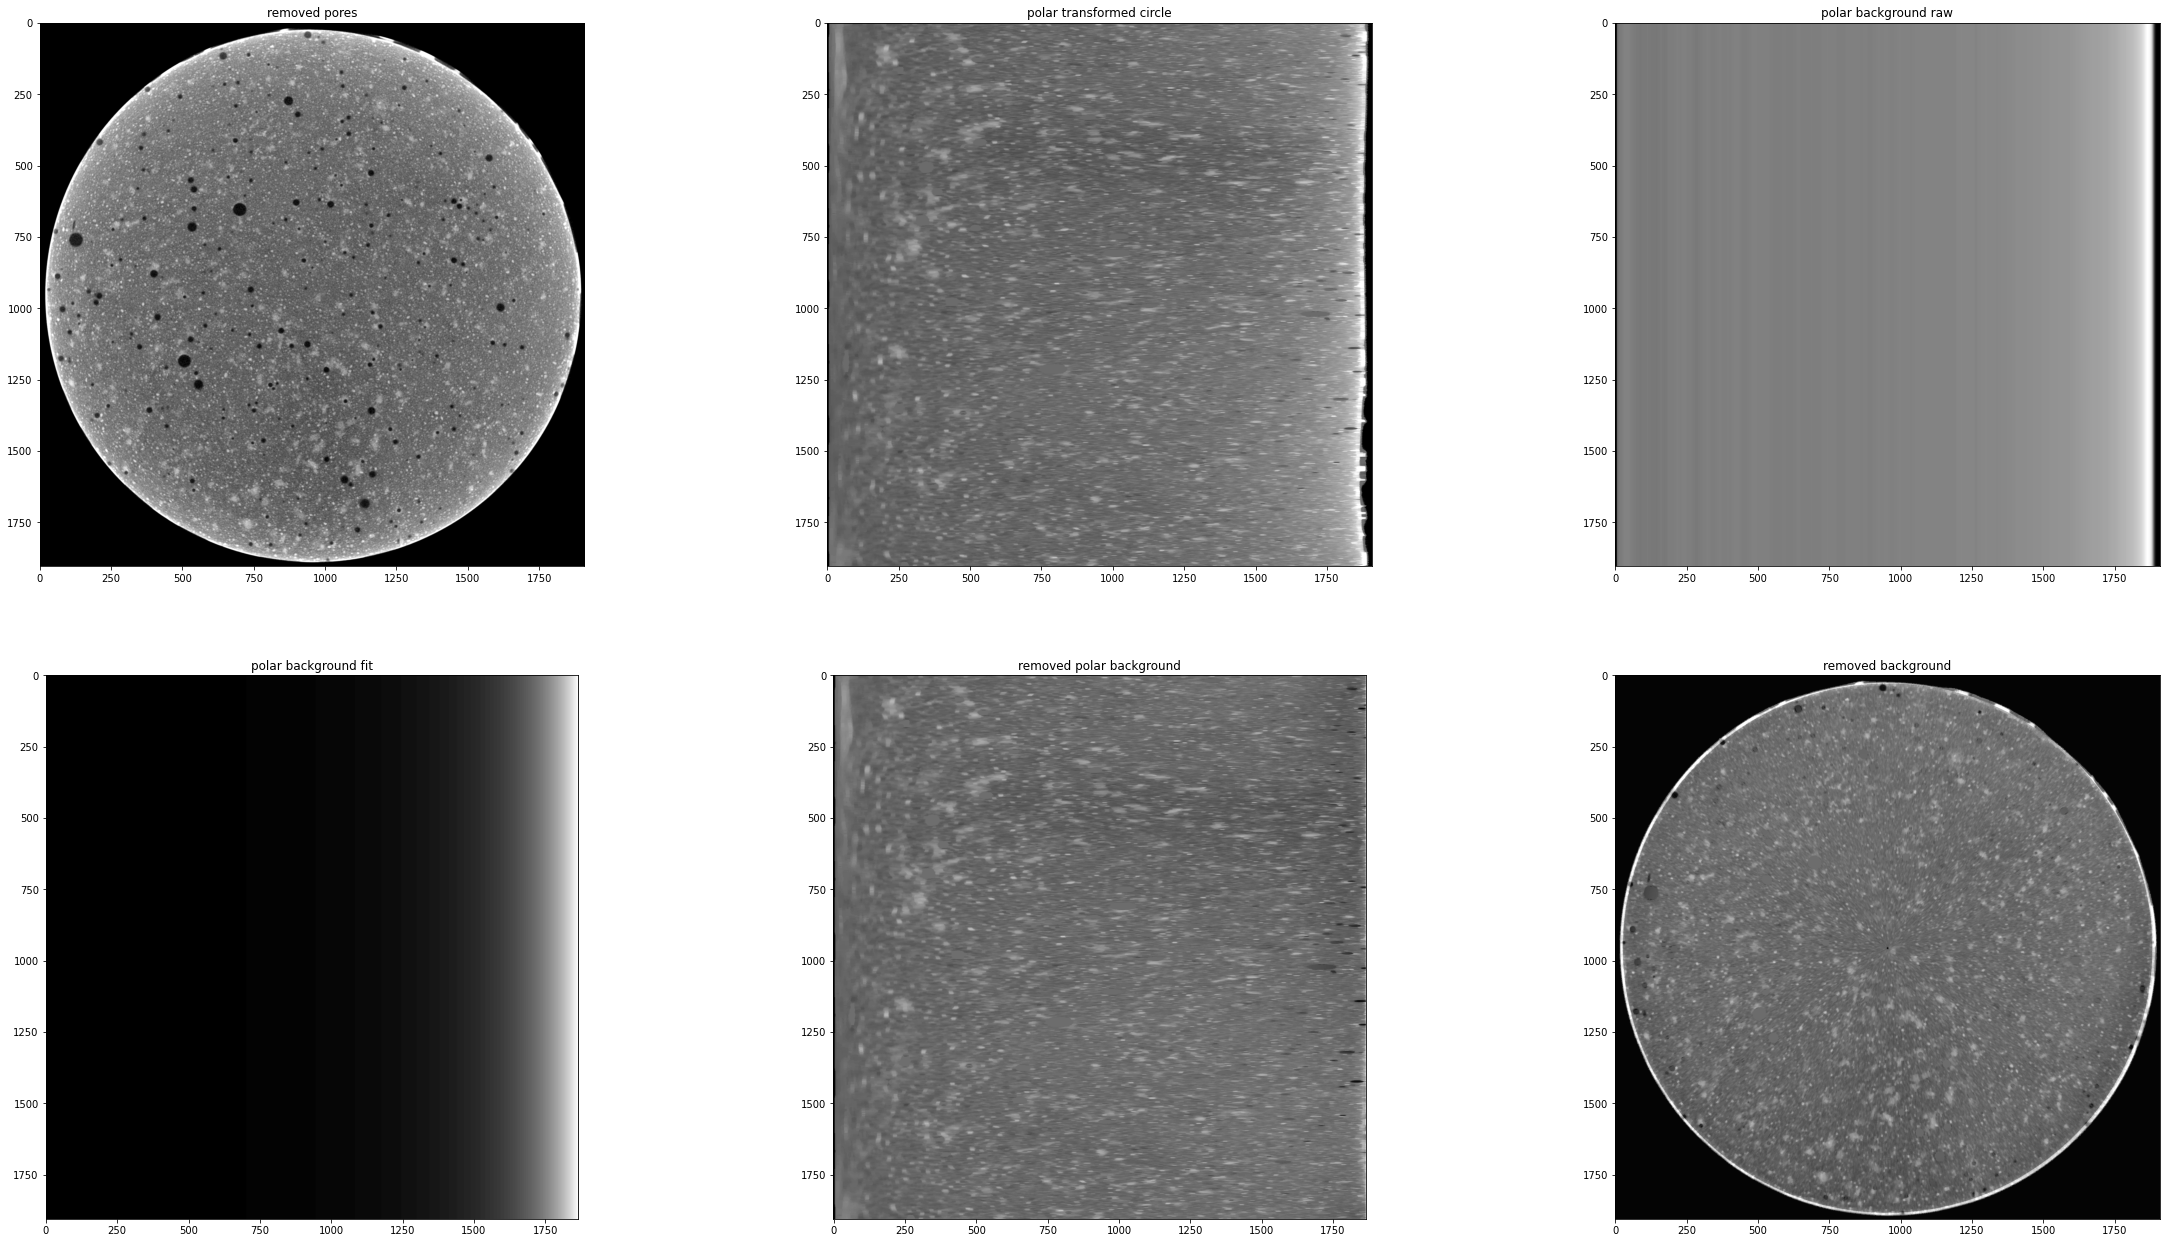

In [10]:
print(polar_background_fit.shape)
print(polar_background_fit[:, 0:max_pos].shape)

fixed_image = (polar_image-polar_background_fit)
unpolar = cv2.linearPolar(fixed_image,(CT.center[0], CT.center[1]), min_length, cv2.WARP_INVERSE_MAP)

fig, ax = plt.subplots(2,3, figsize=(40,22))
#fig.suptitle( "raw images", fontsize=16 )
ax[0,0].imshow( slice, cmap='gray' )
ax[0,0].set_title( "removed pores" )
ax[0,1].imshow( polar_image, cmap='gray' )
ax[0,1].set_title( "polar transformed circle" )
ax[0,2].imshow( polar_background, cmap='gray' )
ax[0,2].set_title( "polar background raw" )
ax[1,0].imshow( polar_background_fit[:, 0:max_pos], cmap='gray' )
ax[1,0].set_title( "polar background fit" )
ax[1,1].imshow( fixed_image[:, 0:max_pos], cmap='gray' )
ax[1,1].set_title( "removed polar background" )
ax[1,2].imshow( unpolar, cmap='gray' )
ax[1,2].set_title( "removed background" )